# Imports and Installs

In [1]:
!pip install sentence_transformers
!pip install keybert

In [2]:
import re
import nltk
import string
import sklearn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keybert import KeyBERT
from transformers import pipeline
from tabulate import tabulate

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Accessing Data and Preprocessing

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
movie_data = pd.read_csv('movies.csv')
anime_data = pd.read_csv('anime.csv')

In [5]:
movie_data.shape

(10000, 6)

In [6]:
anime_data.shape

(14952, 25)

In [7]:
#Basic summary of missing values and statistics
print("Missing Values:\n", movie_data.isnull().sum())

Missing Values:
 Unnamed: 0            0
title                 0
overview             30
original_language     0
vote_count            0
vote_average          0
dtype: int64


In [8]:
print("Missing Values:\n", anime_data.isnull().sum())

Missing Values:
 anime_id            0
Name                0
Score               0
Genres              0
English name        0
Japanese name       0
sypnopsis        1350
Type                0
Episodes            0
Aired               0
Premiered           0
Producers           0
Licensors           0
Studios             0
Source              0
Duration            0
Rating              0
Ranked           1721
Popularity          0
Members             0
Favorites           0
Watching            0
Completed           0
On-Hold             0
Dropped             0
dtype: int64


In [9]:
# Drop rows with NaN values in relevant columns for both datasets
movie_data = movie_data.dropna(subset=['overview'])
anime_data = anime_data.dropna(subset=['sypnopsis'])
print(movie_data.shape)
print(anime_data.shape)

(9970, 6)
(13602, 25)


In [10]:
def preprocess_text(text):
    if isinstance(text, str):  # Check if text is a string
        text = text.lower()  # Convert to lowercase
        tokens = word_tokenize(text)  # Tokenize text
        tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation and special characters
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        lemmatizer = WordNetLemmatizer()
        return ' '.join(tokens)
    else:
        return ""  # Return an empty string if text is NaN

# Apply preprocessing to movie and anime overviews/summaries
movie_data['cleaned_overview'] = movie_data['overview'].apply(preprocess_text)
anime_data['cleaned_overview'] = anime_data['sypnopsis'].apply(preprocess_text)

# Exploratory Data Analysis

 This section involves loading datasets, cleaning text data, and preparing it for analysis by applying tokenization, stopword removal, and lemmatization.

In [11]:
anime_data.head()

,anime_id,Name,Score,Genres,English name,Japanese name,sypnopsis,Type,Episodes,Aired,...,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,cleaned_overview
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,"In the year 2071, humanity has colonized sever...",TV,26,"Apr 3, 1998 to Apr 24, 1999",...,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,year humanity colonized several planets moons ...
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,"other day, another bounty—such is the life of ...",Movie,1,"Sep 1, 2001",...,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,day another life often unlucky crew bebop howe...
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,"Vash the Stampede is the man with a $$60,000,0...",TV,26,"Apr 1, 1998 to Sep 30, 1998",...,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,vash stampede man bounty head reason merciless...
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),ches are individuals with special powers like ...,TV,26,"Jul 2, 2002 to Dec 24, 2002",...,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,ches individuals special powers like esp telek...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,It is the dark century and the people are suff...,TV,52,"Sep 30, 2004 to Sep 29, 2005",...,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,dark century people suffering rule devil vande...


In [12]:
movie_data.head()

,Unnamed: 0,title,overview,original_language,vote_count,vote_average,cleaned_overview
0,0,Ad Astra,"The near future, a time when both hope and har...",en,2853,5.9,near future time hope hardships drive humanity...
1,1,Bloodshot,"After he and his wife are murdered, marine Ray...",en,1349,7.2,wife murdered marine ray garrison resurrected ...
2,2,Bad Boys for Life,Marcus and Mike are forced to confront new thr...,en,2530,7.1,marcus mike forced confront new threats career...
3,3,Ant-Man,Armed with the astonishing ability to shrink i...,en,13611,7.1,armed astonishing ability shrink scale increas...
4,4,Percy Jackson: Sea of Monsters,"In their quest to confront the ultimate evil, ...",en,3542,5.9,quest confront ultimate evil percy friends bat...


In [13]:
#Top 10 languages
top_languages = movie_data['original_language'].value_counts().head(10)
print("\nTop 10 Languages:\n", top_languages)


Top 10 Languages:
 original_language
en    8321
fr     376
ja     269
it     146
es     143
de      96
ko      92
cn      72
ru      69
hi      69
Name: count, dtype: int64


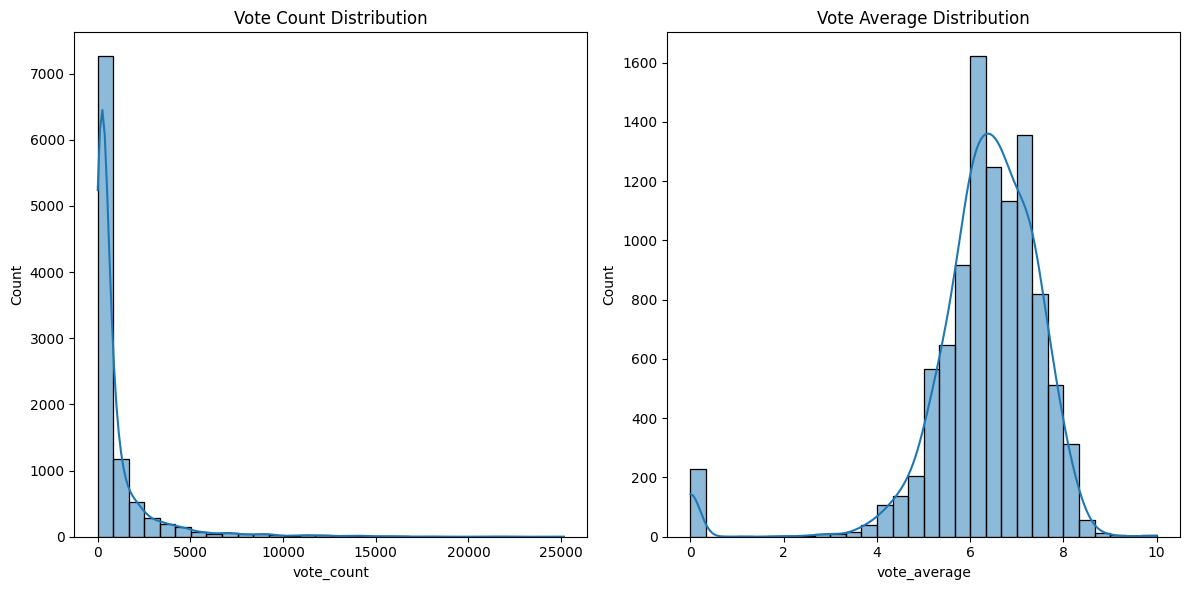

In [ ]:
# Plot distribution of 'vote_count' and 'vote_average' columns in the movie data
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 2 subplots side by side, set the figure size

# Plot the distribution of 'vote_count'
sns.histplot(movie_data['vote_count'], bins=30, ax=axes[0], kde=True)  # Create a histogram with KDE for 'vote_count'
axes[0].set_title("Vote Count Distribution")  # Set the title for the first subplot

# Plot the distribution of 'vote_average'
sns.histplot(movie_data['vote_average'], bins=30, ax=axes[1], kde=True)  # Create a histogram with KDE for 'vote_average'
axes[1].set_title("Vote Average Distribution")  # Set the title for the second subplot

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Display the plots
plt.show()

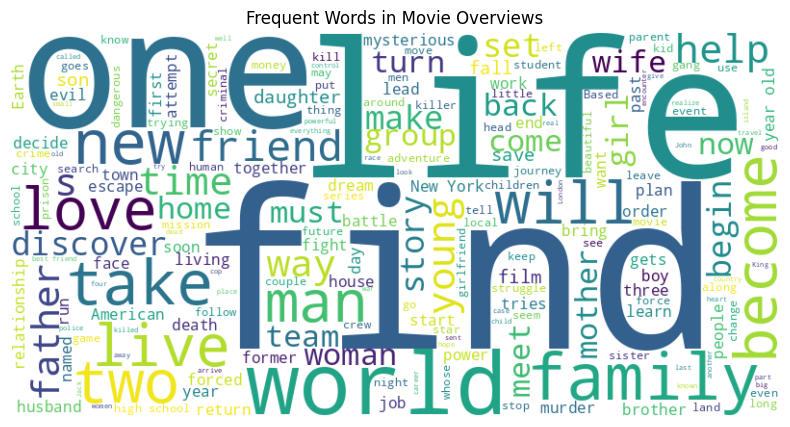

In [ ]:
# Combine all non-NaN overviews into a single string
all_overviews = " ".join(movie_data['overview'].dropna())

# Create a WordCloud object with specified dimensions and background color
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_overviews)

plt.figure(figsize=(10, 5))  # Define the figure size (width x height in inches)
plt.imshow(wordcloud, interpolation="bilinear")  # Display the word cloud using bilinear interpolation for smooth scaling
plt.axis("off")  # Remove axes for a cleaner visualization
plt.title("Frequent Words in Movie Overviews")  # Add a title to the word cloud
plt.show()  # Display the plot

#Searching for similar movies

Using Tfidf vectorization we have ensured we can list 5 movies similar to the one entered based on the semantic similatiy between the overview or synopsis of the movies.

In [ ]:
# Fill NaN overviews with an empty string to avoid issues
movie_data['overview'].fillna('', inplace=True)

# 1. Apply TF-IDF to the 'overview' column
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(movie_data['overview'])

# Display the TF-IDF matrix shape (number of movies x number of features)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# 2. Calculate cosine similarity between movies based on the 'overview' TF-IDF features
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Example: Get the most similar movies for a given movie index (e.g., index 0)
# Find top 5 similar movies
movie_index = 55
similar_indices = cosine_sim[movie_index].argsort()[-6:-1][::-1]
print("\nMovies similar to '{}':".format(movie_data.iloc[movie_index]['title']))
for idx in similar_indices:
    print("-", movie_data.iloc[idx]['title'])

TF-IDF Matrix Shape: (9970, 1000)

Movies similar to 'Jurassic World: Fallen Kingdom':
- Jurassic World
- Action Point
- Jurassic Park
- Free Willy
- The Nut Job 2: Nutty by Nature


#Sentiment/Emotion and thematic analysis

This section focuses on analyzing the sentiment, emotions, and key themes within the text data using LDA among other methods.

In [14]:
# Initialize emotion model and sentiment analyzer
emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")
emotion_classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion")
nltk.download('vader_lexicon')  # Download the VADER lexicon
sia = SentimentIntensityAnalyzer()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [15]:
GENRE_KEYWORDS = {
    'Sci-Fi': ['science fiction', 'sci-fi', 'space', 'robot', 'alien', 'futuristic', 'cyberpunk', 'mecha', 'technology'],
    'Fantasy': ['fantasy', 'magic', 'magical', 'dragon', 'kingdom', 'sword', 'quest', 'demon', 'wizard', 'mythical'],
    'Adventure': ['adventure', 'journey', 'exploration', 'expedition', 'travel', 'treasure', 'heroic', 'epic'],
    'Action': ['action', 'fight', 'battle', 'combat', 'war', 'explosive', 'violence', 'martial arts', 'swords', 'fights'],
    'Drama': ['drama', 'emotional', 'relationships', 'family', 'love', 'heartfelt', 'tearjerker', 'intense'],
    'Crime': ['crime', 'detective', 'murder', 'investigation', 'police', 'heist', 'underworld', 'mafia'],
    'Mystery': ['mystery', 'secret', 'thriller', 'whodunit', 'detective', 'unsolved', 'puzzle'],
    'Comedy': ['comedy', 'funny', 'humor', 'satire', 'parody', 'joke', 'slapstick', 'gag'],
    'Supernatural': ['supernatural', 'ghost', 'spirit', 'occult', 'haunting', 'psychic', 'paranormal', 'witches'],
    'Romance': ['romance', 'love', 'relationship', 'heart', 'romantic', 'couple', 'affection', 'shoujo'],
    'Horror': ['horror', 'scary', 'fear', 'terror', 'creepy', 'gore', 'dark', 'monster', 'nightmare'],
    'Shounen': ['shounen', 'youth', 'action-packed', 'friendship', 'hero', 'battle', 'growth'],
    'Slice of Life': ['slice of life', 'everyday', 'ordinary', 'school', 'realistic', 'wholesome', 'daily life'],
    'Isekai': ['isekai', 'other world', 'parallel world', 'transported', 'reincarnation'],
    'Mecha': ['mecha', 'giant robot', 'mechanical', 'mechs', 'pilot', 'cyber'],
    'Seinen': ['seinen', 'mature', 'adult', 'dark themes', 'psychological'],
    'Shoujo': ['shoujo', 'romantic', 'young girl', 'love story'],
} # Some preset keywords to aid in matching


# Function to clean the text (remove numbers and non-English words)
def clean_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove non-English characters (keep only alphabetic and basic punctuation)
    text = re.sub(r'[^a-zA-Z\s.,!?\'"]', '', text)
    return text

# Function to get the top N emotions from a text
def get_top_n_emotions(text, emotion_model, n=5):
    emotions = emotion_model(text)
    emotions_sorted = sorted(emotions, key=lambda x: x['score'], reverse=True)
    return [emotion['label'] for emotion in emotions_sorted[:n]]

# Function to perform sentiment analysis
def get_sentiment(text, sentiment_analyzer):
    sentiment_score = sentiment_analyzer.polarity_scores(text)
    sentiment = "positive" if sentiment_score['compound'] >= 0.05 else "negative" if sentiment_score['compound'] <= -0.05 else "neutral"
    return sentiment, sentiment_score

def extract_genres(text, genre_keywords):
    if not isinstance(text, str) or text.strip() == "":
        return []

    text = text.lower()  # Convert text to lowercase for matching
    matched_genres = set()

    # Match keywords to genres
    for genre, keywords in genre_keywords.items():
        for keyword in keywords:
            if keyword in text:  # Partial matching
                matched_genres.add(genre)

    return list(matched_genres)


# Function to extract theme/genre based on LDA topics
def get_topic_keywords(X, lda, vectorizer, n_top_words=5):
    feature_names = vectorizer.get_feature_names_out()
    topic_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        topic_words.append(" ".join([feature_names[i] for i in top_words_idx]))
    return topic_words

# Function to assign the theme/genre to each summary
def assign_theme(row_idx, lda_topics, topic_words):
    topic_dist = lda_topics[row_idx]
    top_topic_idx = np.argmax(topic_dist)
    return topic_words[top_topic_idx]

# processing movie data in batches
def process_movie_data_with_genres_batch(movie_data, emotion_model, sentiment_analyzer, batch_size=5, n_emotions=5):
    # Initialize an empty list to collect processed batches
    processed_batches = []

    sample_movie_data = movie_data.head(500)  # Using a smaller sample for testing

    # Process the dataset in batches
    for start_idx in range(0, len(sample_movie_data), batch_size):
        end_idx = min(start_idx + batch_size, len(sample_movie_data))
        movie_data_batch = sample_movie_data[['title', 'overview', 'cleaned_overview']].iloc[start_idx:end_idx].copy() # Create copy

        # Reset index for movie_data_batch to start from 0 for each batch
        movie_data_batch = movie_data_batch.reset_index(drop=True)

        # Process emotions for the current batch
        movie_data_batch['emotion_sentiment'] = [
            get_top_n_emotions(text, emotion_model, n=n_emotions) + [get_sentiment(text, sentiment_analyzer)[0]]
            for text in movie_data_batch['cleaned_overview']
        ]

        # Extract themes using LDA
        vectorizer = CountVectorizer(stop_words="english")
        X = vectorizer.fit_transform(movie_data_batch['overview'])
        lda = LatentDirichletAllocation(n_components=5, random_state=42)
        lda_topics = lda.fit_transform(X)
        topic_words = get_topic_keywords(X, lda, vectorizer)

        # Assign theme using the reset index
        movie_data_batch['theme'] = movie_data_batch.index.map(lambda row_idx: assign_theme(row_idx, lda_topics, topic_words))

        # Extract genres for the current batch
        movie_data_batch['genres'] = movie_data_batch['overview'].apply(
            lambda text: extract_genres(text, GENRE_KEYWORDS)
        )

        # Append processed batch to the list
        processed_batches.append(movie_data_batch[['title', 'emotion_sentiment', 'theme', 'genres']])

    # Concatenate all processed batches into a single DataFrame
    result = pd.concat(processed_batches, ignore_index=True)
    return result

def process_anime_data_with_genres_batch(anime_data, emotion_model, sentiment_analyzer, batch_size=5, n_emotions=5):
    # Initialize an empty list to collect processed batches
    processed_batches = []

    sample_anime_data = anime_data.head(500)  # Using a smaller sample for testing

    # Process the dataset in batches
    for start_idx in range(0, len(sample_anime_data), batch_size):
        end_idx = min(start_idx + batch_size, len(sample_anime_data))
        anime_data_batch = sample_anime_data[['Name', 'sypnopsis']].iloc[start_idx:end_idx].copy() # Create copy

        # Reset index for anime_data_batch to start from 0 for each batch
        anime_data_batch = anime_data_batch.reset_index(drop=True)

        # Clean the synopsis
        anime_data_batch['cleaned_sypnopsis'] = anime_data_batch['sypnopsis'].apply(clean_text)

        # Process emotions for the current batch
        anime_data_batch['emotion_sentiment'] = [
            get_top_n_emotions(text, emotion_model, n=n_emotions) + [get_sentiment(text, sentiment_analyzer)[0]]
            for text in anime_data_batch['cleaned_sypnopsis']
        ]

        # Extract themes using LDA
        vectorizer = CountVectorizer(stop_words="english")
        X = vectorizer.fit_transform(anime_data_batch['cleaned_sypnopsis'])
        lda = LatentDirichletAllocation(n_components=15, random_state=42)  # 15 topics for anime
        lda_topics = lda.fit_transform(X)
        topic_words = get_topic_keywords(X, lda, vectorizer)

        # Assign theme using the reset index
        anime_data_batch['theme'] = anime_data_batch.index.map(lambda row_idx: assign_theme(row_idx, lda_topics, topic_words))

        # Extract genres for the current batch
        anime_data_batch['genres'] = anime_data_batch['cleaned_sypnopsis'].apply(
            lambda text: extract_genres(text, GENRE_KEYWORDS)
        )

        # Append processed batch to the list
        processed_batches.append(anime_data_batch[['Name', 'emotion_sentiment', 'theme', 'genres']])

    # Concatenate all processed batches into a single DataFrame
    result = pd.concat(processed_batches, ignore_index=True)
    return result

# Initialize models
emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")
sia = SentimentIntensityAnalyzer()

# Process movie and anime data
movie_results = process_movie_data_with_genres_batch(movie_data, emotion_model, sia, batch_size=5, n_emotions=5)
anime_results = process_anime_data_with_genres_batch(anime_data, emotion_model, sia, batch_size=5, n_emotions=5)

limited_movie_results = movie_results[:15]
limited_anime_results = anime_results[:15]

# Display results
print("Movie Data Results:")
print(tabulate(limited_movie_results, headers='keys', tablefmt='pretty', showindex=False))

print("\nAnime Data Results:")
print(tabulate(limited_anime_results, headers='keys', tablefmt='pretty', showindex=False))

Movie Data Results:
+----------------------------------------------------------------------+--------------------------+------------------------------------------+------------------------------------------------------+
|                                title                                 |    emotion_sentiment     |                  theme                   |                        genres                        |
+----------------------------------------------------------------------+--------------------------+------------------------------------------+------------------------------------------------------+
|                               Ad Astra                               |   ['fear', 'negative']   |     life humanity stars planet space     |               ['Adventure', 'Sci-Fi']                |
|                              Bloodshot                               |  ['anger', 'negative']   |      wife ray mythical evil marine       |                 ['Crime', 'Sci-Fi']          

## Implementing Word2Vec for Semantic Similarity Search


In [16]:
!pip install gensim

In [17]:
import os

file_path = "GoogleNews-vectors-negative300.bin"
if os.path.exists(file_path):
    print(f"File exists. Size: {os.path.getsize(file_path) / (1024 * 1024):.2f} MB")
else:
    print("File does not exist.")

File exists. Size: 3475.44 MB


In [18]:
from gensim.models import KeyedVectors

# Load the model (path should match the downloaded file)
word_tokenized_path = "GoogleNews-vectors-negative300.bin"
word2vec_model = KeyedVectors.load_word2vec_format(word_tokenized_path, binary=True)

In [19]:
import numpy as np

def get_word2vec_embedding(text, model):
    words = text.split()
    valid_vectors = [model[word] for word in words if word in model]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def generate_word2vec_embeddings(data, text_column, model):
    data['word2vec_embedding'] = data[text_column].apply(lambda x: get_word2vec_embedding(x, model))
    return data

# Assuming you have preprocessed summaries in 'cleaned_overview' column
movie_data = generate_word2vec_embeddings(movie_data, 'cleaned_overview', word2vec_model)
anime_data = generate_word2vec_embeddings(anime_data, 'cleaned_overview', word2vec_model)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(movie_embeddings, anime_embeddings):
    return cosine_similarity(np.vstack(movie_embeddings), np.vstack(anime_embeddings))

# Extract embeddings into numpy arrays
movie_embeddings = np.array(movie_data['word2vec_embedding'].tolist())
anime_embeddings = np.array(anime_data['word2vec_embedding'].tolist())

# Compute similarity matrix
similarity_matrix = calculate_similarity(movie_embeddings, anime_embeddings)

In [21]:
def rank_recommendations(similarity_matrix, top_n=5):
    """
    Rank recommendations for each movie based on similarity scores.
    """
    recommendations = []
    for movie_similarities in similarity_matrix:
        ranked_indices = np.argsort(-movie_similarities)[:top_n]  # Top N recommendations
        recommendations.append(ranked_indices)
    return recommendations

# Rank recommendations
ranked_recommendations = rank_recommendations(similarity_matrix, top_n=5)

# Display recommendations
for i, movie in enumerate(movie_data['cleaned_overview']):
    print(f"Movie: {movie}")
    print("Recommended Anime:")
    for idx in ranked_recommendations[i]:
        print(f" - {anime_data.iloc[idx]['cleaned_overview']}")
    print("\n")

Streaming output truncated to the last 5000 lines.
 - kujo jotaro normal popular japanese thinks possessed spirit locks prison seeing grandfather joseph joestar fighting joseph friend muhammad abdul jotaro learns spirit actually star platinum stand fighting energy given form later mother gains stand becomes sick jotaro learns vampire dio brando revived years defeat jonathan joestar jotaro jotaro decides join joseph abdul trip egypt defeat dio
 - story takes place second half century japanese culture gains popularity west young japanese girl yune accompanies french traveler oscar journey back france offers help family ironwork shop paris oscar nephew claude reluctantly accepts take care yune learn two little common get understand live together paris
 - fter defeating geese howard legendary fighter terry bogard faces german warrior wolfgang krauser suffer humiliating defeat depressed loss terry wanders around country wasting life drinking young boy named tony convince terry go back winni

In [22]:
# processed_movie_data = process_movie_data_with_genres_batch(movie_data, emotion_model, sia, batch_size=5, n_emotions=5)
movie_new_data = movie_results

# processed_anime_data = process_anime_data_with_genres_batch(anime_data, emotion_model, sia, batch_size=5, n_emotions=5)
anime_new_data = anime_results

# Check the updated DataFrame columns
print(movie_new_data.columns)

Index(['title', 'emotion_sentiment', 'theme', 'genres'], dtype='object')


In [23]:
# Recompute Word2Vec embeddings for filtered datasets
movie_new_data['word2vec_embedding'] = movie_data['cleaned_overview'].apply(
    lambda x: get_word2vec_embedding(x, word2vec_model)
)
anime_new_data['word2vec_embedding'] = anime_data['cleaned_overview'].apply(
    lambda x: get_word2vec_embedding(x, word2vec_model)
)

# Verify that embeddings have been added
print(movie_new_data[['title', 'word2vec_embedding']].head())
print(anime_new_data[['Name', 'word2vec_embedding']].head())

                            title  \
0                        Ad Astra   
1                       Bloodshot   
2               Bad Boys for Life   
3                         Ant-Man   
4  Percy Jackson: Sea of Monsters   

                                  word2vec_embedding  
0  [0.059530724, 0.09986692, 0.015961519, 0.04411...  
1  [0.018395318, 0.1040997, 0.10875448, 0.0083245...  
2  [-0.033822518, 0.07110596, -0.0002376415, 0.07...  
3  [0.020827664, 0.10324739, -0.008480072, 0.0649...  
4  [0.123162165, 0.12911648, -0.079318576, 0.0709...  
                              Name  \
0                     Cowboy Bebop   
1  Cowboy Bebop: Tengoku no Tobira   
2                           Trigun   
3               Witch Hunter Robin   
4                   Bouken Ou Beet   

                                  word2vec_embedding  
0  [0.050921224, 0.062177, 0.015461459, 0.0758360...  
1  [0.068724915, 0.054330636, -0.016199302, 0.050...  
2  [0.094378896, 0.08188755, 0.018467383, 0.05613... 

In [24]:
# Extract embeddings for the filtered datasets, ensuring consistent dimensions
movie_embeddings = np.array([emb for emb in movie_new_data['word2vec_embedding'] if isinstance(emb, np.ndarray) and emb.shape == (300,)])
anime_embeddings = np.array([emb for emb in anime_new_data['word2vec_embedding'] if isinstance(emb, np.ndarray) and emb.shape == (300,)])

# Compute the similarity matrix between the filtered datasets
similarity_matrix = cosine_similarity(movie_embeddings, anime_embeddings)

# Verify the shape of the recomputed similarity matrix
print("Recomputed Similarity Matrix Shape:", similarity_matrix.shape)

Recomputed Similarity Matrix Shape: (498, 489)


In [25]:
def display_recommendations_with_sentiment(movie_new_data, anime_new_data, similarity_matrix, top_n=5):
    """
    Display movie-to-anime recommendations with similarity scores, emotions, themes, and genres.
    """
    anime_new_data = anime_new_data.reset_index(drop=True)

    movie_new_data = movie_new_data.reset_index(drop=True)  # Reset movie_new_data index

    # Iterate through movie_new_data using its index
    for i in range(20):
        movie = movie_new_data.iloc[i]
        print(f"Movie: {movie['title']}")
        print(f"  Emotion Sentiment: {movie['emotion_sentiment']}")
        print(f"  Theme: {movie['theme']}")
        print(f"  Genres: {', '.join(movie['genres']) if movie['genres'] else 'N/A'}")
        print("\nTop Anime Recommendations:")

        # Get top N recommendations, ensuring i is within bounds
        if i < similarity_matrix.shape[0]:
            top_indices = np.argsort(-similarity_matrix[i])[:top_n]
            for rank, idx in enumerate(top_indices, start=1):
                if idx >= len(anime_new_data):
                    print(f"  Error: Index {idx} is out of bounds for anime_new_data.")
                    continue
                anime = anime_new_data.iloc[idx]
                print(f"  {rank}. Anime: {anime['Name']}")
                print(f"     Similarity Score: {similarity_matrix[i, idx]:.2f}")
                print(f"     Emotion Sentiment: {anime['emotion_sentiment']}")
                print(f"     Theme: {anime['theme']}")
                print(f"     Genres: {', '.join(anime['genres']) if anime['genres'] else 'N/A'}")
            print("\n" + "-"*80 + "\n")
        else:
            print(f"  Skipping movie index {i} as it's out of bounds for the similarity matrix.")
            print("\n" + "-"*80 + "\n")

In [26]:
display_recommendations_with_sentiment(movie_new_data, anime_new_data, similarity_matrix, top_n=5)

Movie: Ad Astra
  Emotion Sentiment: ['fear', 'negative']
  Theme: life humanity stars planet space
  Genres: Adventure, Sci-Fi

Top Anime Recommendations:
  1. Anime: Neon Genesis Evangelion
     Similarity Score: 0.82
     Emotion Sentiment: ['fear', 'positive']
     Theme: head evangelion ikari evangelions face
     Genres: Drama, Seinen, Adventure, Shounen, Mystery, Mecha
  2. Anime: Sousei no Aquarion
     Similarity Score: 0.82
     Emotion Sentiment: ['neutral', 'positive']
     Theme: angels shadow aquarion humanity brought
     Genres: Action, Shounen, Mecha, Horror, Romance, Sci-Fi
  3. Anime: Planetes
     Similarity Score: 0.82
     Emotion Sentiment: ['sadness', 'positive']
     Theme: space debris ai section earth
     Genres: Adventure, Slice of Life, Sci-Fi
  4. Anime: Turn A Gundam
     Similarity Score: 0.81
     Emotion Sentiment: ['neutral', 'negative']
     Theme: earth rolan moon people white
     Genres: Mecha, Action, Drama
  5. Anime: Gilgamesh
     Similarity 

## Enhanced Cross Domain Reccomendation Engine

In the next segment we test our enhanced pipeline where both the cosine simialrity from the summary/overview and the emotion and sentiments are factored in. This completes our obejctive.

In [35]:
!pip install vaderSentiment

ERROR: Operation cancelled by user


In [32]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

def compute_combined_similarity(movie_data, anime_data, embedding_weight=0.8, emotion_weight=0.2, top_n=5):
    """
    Perform enhanced similarity-based recommendations for movies and animes.
    """
    recommendations = []

    # Iterate through each movie
    for _, movie_row in movie_data.iterrows():
        movie_title = movie_row['title']
        movie_embedding = movie_row['word2vec_embedding']
        movie_emotion_sentiment = set(movie_row['emotion_sentiment'])  # Convert to set for Jaccard

        # Initialize a list to store similarity scores
        anime_scores = []

        # Iterate through each anime
        for _, anime_row in anime_data.iterrows():
            anime_name = anime_row['Name']
            anime_embedding = anime_row['word2vec_embedding']
            anime_emotion_sentiment = set(anime_row['emotion_sentiment'])  # Convert to set for Jaccard

            # Check if embeddings are valid before calculating similarity
            if isinstance(movie_embedding, np.ndarray) and isinstance(anime_embedding, np.ndarray):
                # Calculate Word2Vec embedding similarity, reshaping if necessary
                movie_embedding_reshaped = movie_embedding.reshape(1, -1)  # Reshape to 2D
                anime_embedding_reshaped = anime_embedding.reshape(1, -1)  # Reshape to 2D
                embedding_similarity = cosine_similarity(movie_embedding_reshaped, anime_embedding_reshaped)[0][0]

                # Calculate Jaccard similarity for emotion_sentiment
                emotion_similarity = jaccard_similarity(movie_emotion_sentiment, anime_emotion_sentiment)

                # Combine similarities with respective weights
                combined_similarity = (embedding_weight * embedding_similarity) + (emotion_weight * emotion_similarity)

                # Append results
                anime_scores.append((anime_name, combined_similarity))
            else:
                # Handle invalid embeddings, e.g., assign a low similarity score
                anime_scores.append((anime_name, 0.0))  # Or any other appropriate value

        # Sort animes by combined similarity score in descending order
        anime_scores = sorted(anime_scores, key=lambda x: x[1], reverse=True)

        # Select top_n animes
        top_anime = [anime[0] for anime in anime_scores[:top_n]]

        # Append recommendations for the current movie
        recommendations.append({
            'movie_title': movie_title,
            'recommended_animes': top_anime
        })

    return recommendations

In [34]:
compute_combined_similarityrecommendations = compute_combined_similarity(
    movie_data=movie_new_data,
    anime_data=anime_new_data,
    embedding_weight=0.8,
    emotion_weight=0.2,
    top_n=5                # Number of recommendations
)

# Display recommendations
for rec in compute_combined_similarityrecommendations: # Changed from recommendations
    print(f"Movie: {rec['movie_title']}")
    print(f"Top Anime Recommendations: {', '.join(rec['recommended_animes'])}")
    print()

Movie: Ad Astra
Top Anime Recommendations: Serial Experiments Lain, Xenosaga The Animation, Neon Genesis Evangelion: Death & Rebirth, Ima, Soko ni Iru Boku, Innocence

Movie: Bloodshot
Top Anime Recommendations: Great Teacher Onizuka, Kamui no Ken, Jigoku Shoujo, Seikai no Senki III, Trigun

Movie: Bad Boys for Life
Top Anime Recommendations: Bakuretsu Tenshi, Chrno Crusade, Trigun, Ranma ½: Chuugoku Nekonron Daikessen! Okite Yaburi no Gekitou-hen!!, Mobile Suit Gundam SEED Destiny

Movie: Ant-Man
Top Anime Recommendations: Angel Heart, Suzuka, Kurenai no Buta, Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!, FLCL

Movie: Percy Jackson: Sea of Monsters
Top Anime Recommendations: Gensoumaden Saiyuuki, Bokusatsu Tenshi Dokuro-chan, Tenshi Kinryouku, Zettai Shounen, Samurai Deeper Kyou

Movie: Birds of Prey (and the Fantabulous Emancipation of One Harley Quinn)
Top Anime Recommendations: Kaleido Star, Solty Rei, Ikkitousen, B'T X, Stratos 4 OVA

Movie: Live Free or Die